In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torchvision.utils import make_grid
from torchvision import datasets

In [44]:
# Model 0
class Model0(nn.Module):
    def __init__(self):
        super(Model0, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        #print(x.size())
        x = x.view(-1, 64 * 6 * 6) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = x.view(-1, 256 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.2) 
        self.fc1 = nn.Linear(256 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = x.view(-1, 256 * 3 * 3)  
        x = self.dropout(x)  
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Files already downloaded and verified


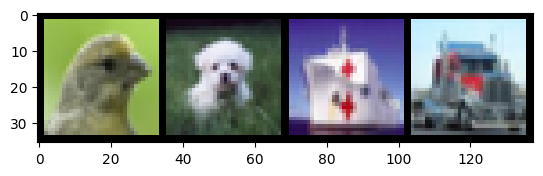

 bird   dog  ship truck


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Visualize some images from the training set
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset_untransformed = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader_untransformed = torch.utils.data.DataLoader(trainset_untransformed, batch_size=4, shuffle=True, num_workers=2)

# Get some random training images
images, labels = next(iter(trainloader_untransformed))

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the dataset only once
whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split it into train and validation sets
trainset, valset = torch.utils.data.random_split(whole_trainset, [round(len(whole_trainset)*0.9), round(len(whole_trainset)*0.1)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
def train_model(model, trainloader, valloader, epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # Lists to store weights, gradients, activations, learning rate, and losses
    # weights = []
    # gradients = []
    # activations = []
    # learning_rate = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Save weights, gradients, activations, learning rate, and training loss
            # for name, param in model.named_parameters():
            #     if 'weight' in name:
            #         weights.append(param.data.cpu().numpy().flatten())
            #         gradients.append(param.grad.data.cpu().numpy().flatten())
            # activations.append(outputs.data.cpu().numpy().flatten())
            # learning_rate.append(scheduler.get_last_lr()[0])
            train_losses.append(loss.item())

            running_loss += loss.item()
            if i % 1000 == 0:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

        # Calculate validation loss
        val_loss = 0.0
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
        print(f'Epoch {epoch+1}, Validation loss: {val_loss / len(valloader)}')

        scheduler.step()

    print('Finished Training')
    # return weights, gradients, activations, learning_rate, train_losses, val_losses
    return None, None, None, None, train_losses, val_losses

In [7]:

def plot_losses(train_losses, val_losses, trainloader, title):
    x_train = np.arange(len(train_losses))
    x_val = np.arange(len(trainloader), len(trainloader)*(len(val_losses)+1), len(trainloader))

    plt.figure(figsize=(12,6))
    plt.plot(x_train, train_losses, label='Training Loss', linewidth = 0.5)
    plt.plot(x_val, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


In [8]:
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))

In [46]:
model0 = Model0()
print("Training model ...")
weights, gradients, activations, lr, train_losses, val_losses = train_model(model0, trainloader, valloader)
torch.save(model0.state_dict(), './models/model0.pth')


Training model ...
[1,     1] loss: 0.002
[1,  1001] loss: 1.506
Epoch 1, Validation loss: 1.1538498409283466
[2,     1] loss: 0.001
[2,  1001] loss: 1.052
Epoch 2, Validation loss: 0.997810097076954
[3,     1] loss: 0.001
[3,  1001] loss: 0.859
Epoch 3, Validation loss: 0.9231785593124536
[4,     1] loss: 0.001
[4,  1001] loss: 0.733
Epoch 4, Validation loss: 0.8573644784016486
[5,     1] loss: 0.001
[5,  1001] loss: 0.629
Epoch 5, Validation loss: 0.9249371507993112
[6,     1] loss: 0.001
[6,  1001] loss: 0.443
Epoch 6, Validation loss: 0.8360364307195712
[7,     1] loss: 0.000
[7,  1001] loss: 0.391
Epoch 7, Validation loss: 0.8380026821142588
[8,     1] loss: 0.000
[8,  1001] loss: 0.365
Epoch 8, Validation loss: 0.8615881443405763
[9,     1] loss: 0.000
[9,  1001] loss: 0.341
Epoch 9, Validation loss: 0.8805806076106353
[10,     1] loss: 0.000
[10,  1001] loss: 0.322
Epoch 10, Validation loss: 0.9048879559223468
[11,     1] loss: 0.000
[11,  1001] loss: 0.291
Epoch 11, Validation 

Accuracy of the network on the test images: 73 %


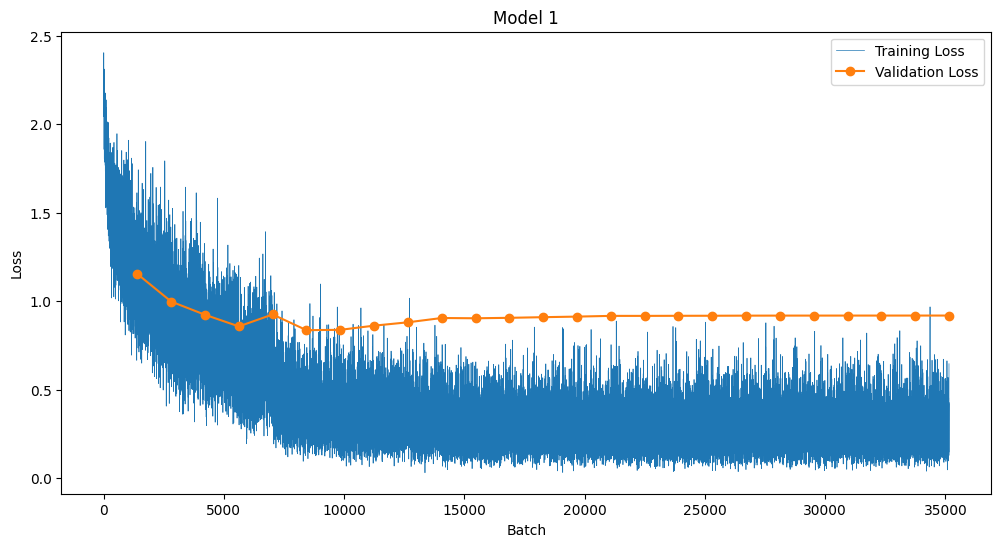

In [47]:
test_model(model0, testloader)
plot_losses(train_losses, val_losses, trainloader,'Model 1')

In [9]:
model1 = Model1()
print("Training model 1...")
weights, gradients, activations, lr, train_losses, val_losses = train_model(model1, trainloader, valloader)
torch.save(model1.state_dict(), './models/model1.pth')


Training model 1...
[1,     1] loss: 0.002
[1,  1001] loss: 1.647
Epoch 1, Validation loss: 1.318176391797188
[2,     1] loss: 0.001
[2,  1001] loss: 1.196
Epoch 2, Validation loss: 1.0980626061940804
[3,     1] loss: 0.001
[3,  1001] loss: 0.972
Epoch 3, Validation loss: 0.9674746688359823
[4,     1] loss: 0.001
[4,  1001] loss: 0.829
Epoch 4, Validation loss: 0.9223371740335073
[5,     1] loss: 0.001
[5,  1001] loss: 0.707
Epoch 5, Validation loss: 0.8998702865762588
[6,     1] loss: 0.001
[6,  1001] loss: 0.473
Epoch 6, Validation loss: 0.8004408983083872
[7,     1] loss: 0.000
[7,  1001] loss: 0.409
Epoch 7, Validation loss: 0.8213432666200858
[8,     1] loss: 0.000
[8,  1001] loss: 0.368
Epoch 8, Validation loss: 0.8307965980508388
[9,     1] loss: 0.000
[9,  1001] loss: 0.332
Epoch 9, Validation loss: 0.8626268941622514
[10,     1] loss: 0.001
[10,  1001] loss: 0.295
Epoch 10, Validation loss: 0.8842798192531635
[11,     1] loss: 0.000
[11,  1001] loss: 0.256
Epoch 11, Validation

Accuracy of the network on the test images: 74 %


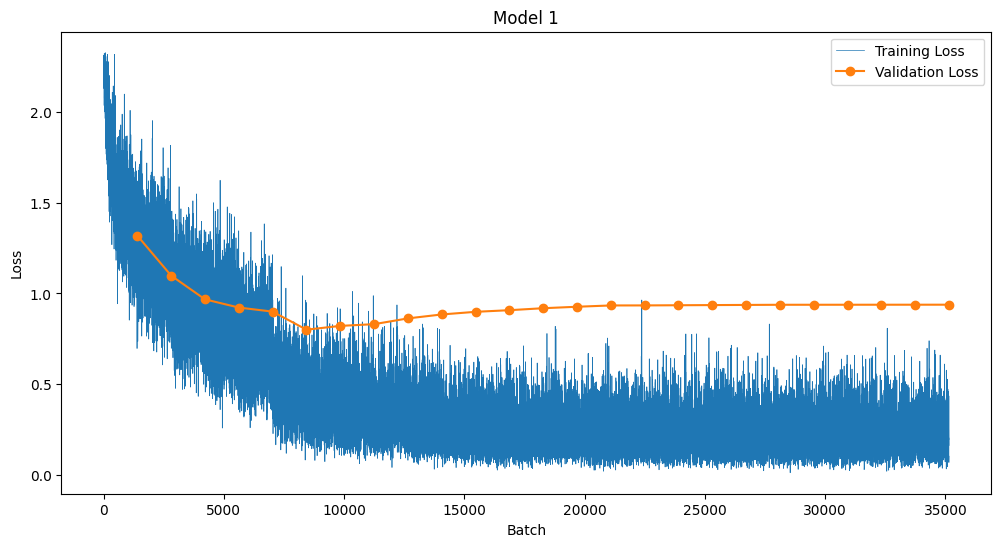

In [10]:
test_model(model1, testloader)
plot_losses(train_losses, val_losses, trainloader,'Model 1')

In [11]:
# goodfit_model = GoodFitConvModel()
# print("Training good fit model...")
# weights, gradients, activations, lr, train_losses, val_losses = train_model(goodfit_model, trainloader, valloader)
# torch.save(goodfit_model.state_dict(), './models/conv_goodfit.pth')

In [12]:
# test_model(goodfit_model, testloader)
# plot_losses(train_losses, val_losses, trainloader,'Good Fit Model')

In [22]:
model2 = Model2()
print("Training model 2...")
weights, gradients, activations, lr, train_losses, val_losses = train_model(model2, trainloader, valloader)
torch.save(model2.state_dict(), './models/model2.pth')

Training model 2...
[1,     1] loss: 0.002
[1,  1001] loss: 1.511
Epoch 1, Validation loss: 1.2354284524917603
[2,     1] loss: 0.001
[2,  1001] loss: 1.106
Epoch 2, Validation loss: 1.0834153772164614
[3,     1] loss: 0.001
[3,  1001] loss: 0.945
Epoch 3, Validation loss: 0.9481944405497649
[4,     1] loss: 0.000
[4,  1001] loss: 0.823
Epoch 4, Validation loss: 0.8776730201565303
[5,     1] loss: 0.001
[5,  1001] loss: 0.733
Epoch 5, Validation loss: 0.8183609656034372
[6,     1] loss: 0.001
[6,  1001] loss: 0.555
Epoch 6, Validation loss: 0.7456854486312622
[7,     1] loss: 0.001
[7,  1001] loss: 0.497
Epoch 7, Validation loss: 0.7336329955321091
[8,     1] loss: 0.000
[8,  1001] loss: 0.462
Epoch 8, Validation loss: 0.7328623705185376
[9,     1] loss: 0.000
[9,  1001] loss: 0.443
Epoch 9, Validation loss: 0.7394676347955679
[10,     1] loss: 0.000
[10,  1001] loss: 0.424
Epoch 10, Validation loss: 0.740446171985987
[11,     1] loss: 0.000
[11,  1001] loss: 0.392
Epoch 11, Validation

Accuracy of the network on the test images: 77 %


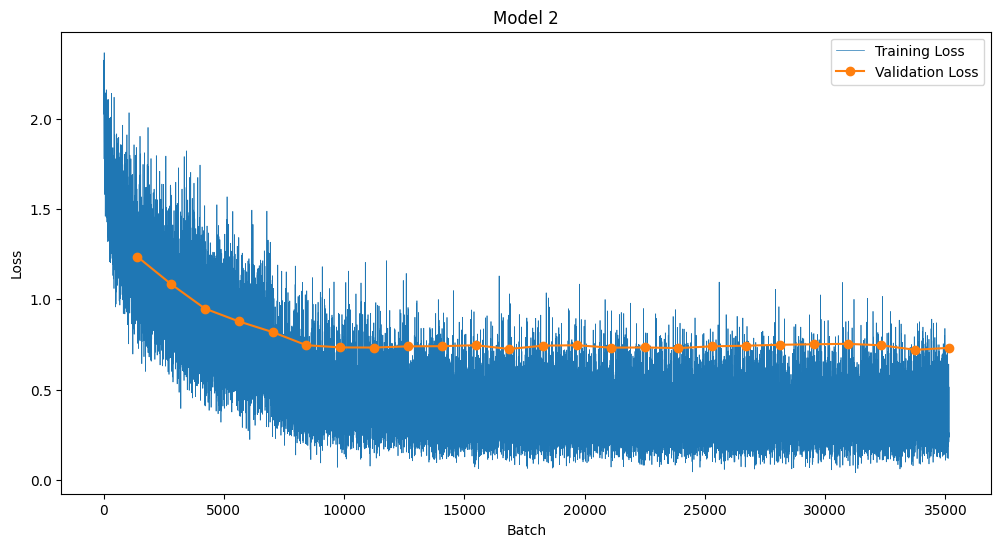

In [23]:
test_model(model2, testloader)
plot_losses(train_losses, val_losses, trainloader,'Model 2')

### Feature Maps

In [30]:
i_img = 102

Files already downloaded and verified
frog


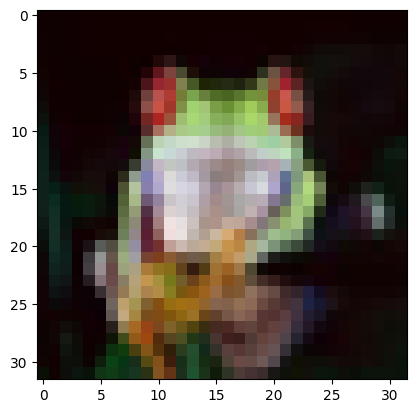

In [31]:
# Choose an image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
image, _ = dataset[i_img]

# Print label and show the image
print(classes[_])
imshow(image)

In [32]:
def plot_feature_maps(model, dataset):

    model_children = list(model.children())

    conv_layers = []
    model_weights = []

    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight)
                    conv_layers.append(child)


    image, _ = dataset[i_img] 
    image = image.unsqueeze(0)

    outputs = []
    names = []

    n_layers_to_plot = len(conv_layers)
    print(f"Total convolution layers: {n_layers_to_plot}")

    for layer in conv_layers:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))

    # Create a function to normalize the feature maps so they can be visualized
    def normalize(image):
        return (image - image.min()) / (image.max() - image.min())

# Define the figure size for the entire plot
    fig_width = 4*n_layers_to_plot
    fig_height = 4
    fig, axs = plt.subplots(1, n_layers_to_plot, figsize=(fig_width, fig_height))

    if n_layers_to_plot == 1: 
        axs = [axs]

    for i, ax in enumerate(axs):
        feature_map = outputs[i][0]
        if feature_map.shape[0] > 3: 
            feature_map = torch.sum(feature_map, axis=0)
        feature_map = normalize(feature_map)
        ax.imshow(feature_map.cpu().detach(), cmap='viridis')
        ax.set_title(names[i].split('(')[0], fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Feature Maps: Model 0
Total convolution layers: 2


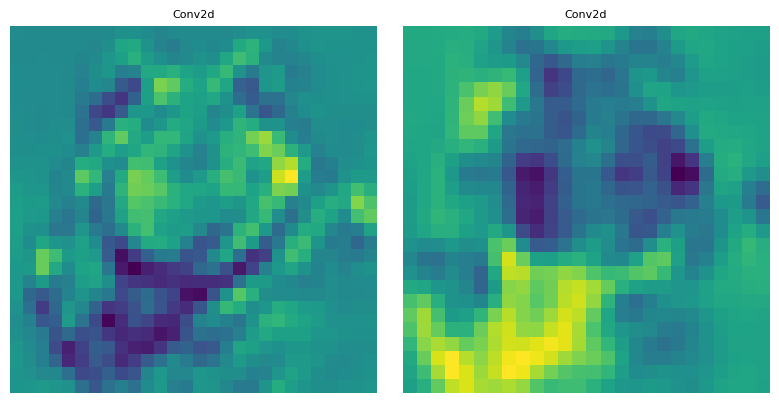

In [48]:
print("Feature Maps: Model 0")
trained_model = Model0()
trained_model.load_state_dict(torch.load('./models/model0.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

Feature Maps: Model 1
Total convolution layers: 4


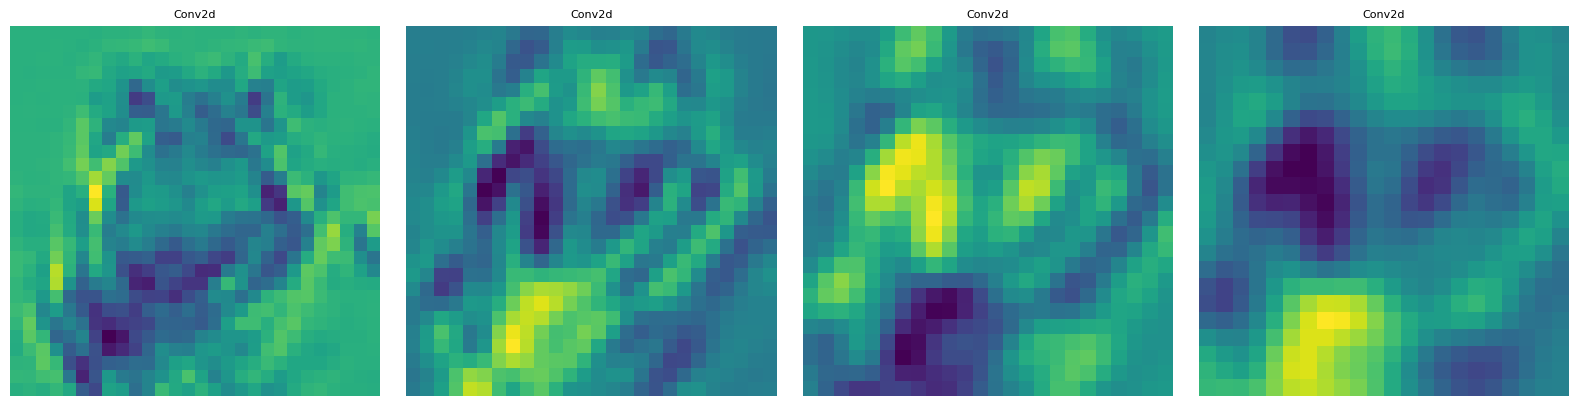

In [33]:
print("Feature Maps: Model 1")
trained_model = Model1()
trained_model.load_state_dict(torch.load('./models/model1.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

In [28]:
# trained_model = GoodFitConvModel()
# trained_model.load_state_dict(torch.load('./models/conv_goodfit.pth'))
# trained_model.eval()
# plot_feature_maps(trained_model, dataset)

Total convolution layers: 4


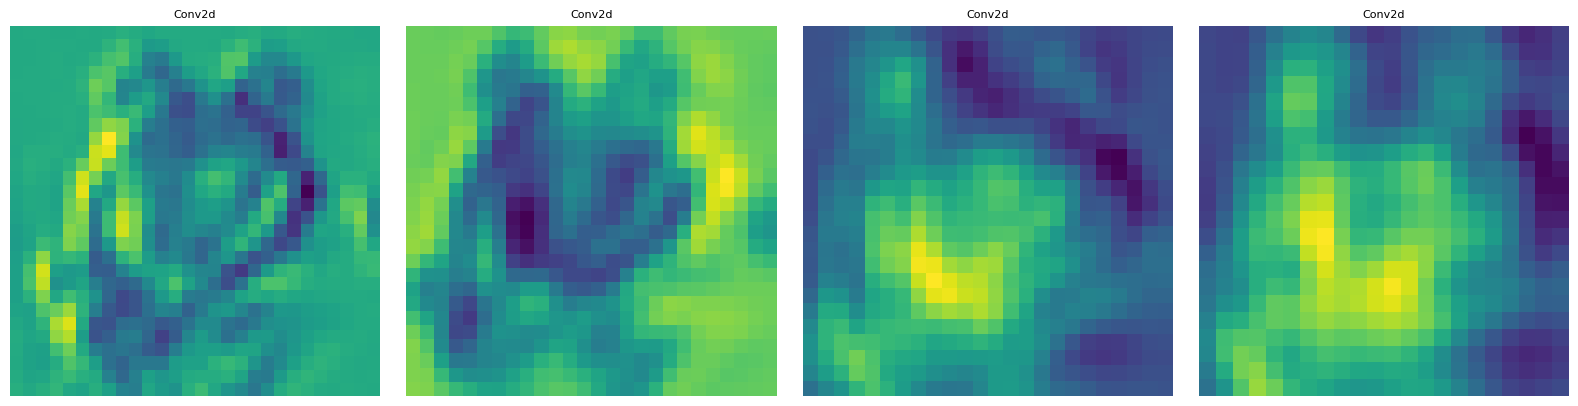

In [34]:

trained_model = Model2()
trained_model.load_state_dict(torch.load('./models/model2.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)
